In [1]:
import pdal
import numpy as np
import pandas as pd
import laspy
import open3d as o3d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import statistics

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Step 1: Read the .laz file
file_path = 'CSF_Filtering_Output.laz'  
lidar_data = laspy.read(file_path)

# Step 2: Prepare the data
# Extract the coordinates
coords = np.vstack((lidar_data.x, lidar_data.y, lidar_data.z)).transpose()

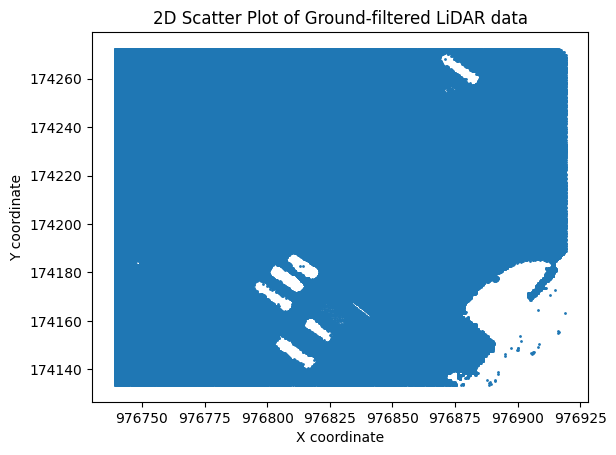

In [3]:
plt.scatter(coords[:, 0], coords[:, 1], s=1)  
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('2D Scatter Plot of Ground-filtered LiDAR data')
plt.show()

z_mean=8.504140004296662
z_std=0.6036658541744861


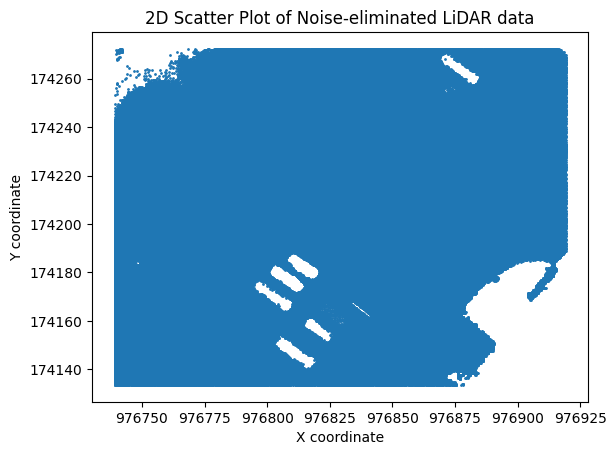

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation of Z values
z_mean = np.mean(coords[:, 2])
z_std = np.std(coords[:, 2])
print(f"z_mean={z_mean}")
print(f"z_std={z_std}")

# Define a threshold for Z values, e.g., within 2 standard deviations from the mean
threshold = 2
# Create a mask to filter out the points based on the threshold
mask = np.abs(coords[:, 2] - z_mean) < threshold * z_std
data_filtered = coords[mask]

# Plot the filtered data
plt.scatter(data_filtered[:, 0], data_filtered[:, 1], s=1)
plt.title("2D Scatter Plot of Noise-eliminated LiDAR data")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()


In [5]:
points_2d = data_filtered[:, :2]

In [6]:
#Step 3: hole detection

#calculate the area of a triangle from its vertices
def calculate_area(v1, v2, v3):
    # Using Heron's formula
    a = np.linalg.norm(v2 - v1)
    b = np.linalg.norm(v3 - v2)
    c = np.linalg.norm(v1 - v3)
    s = (a + b + c) / 2
    area = s * (s - a) * (s - b) * (s - c)
    
    # Check if the area calculation is negative due to floating point inaccuracy
    if area < 0 and np.isclose(area, 0):
        area = 0
    return np.sqrt(area) if area >= 0 else 0

def calculate_aspect_ratio(v1, v2, v3):
    edges = [np.linalg.norm(v2 - v1), np.linalg.norm(v3 - v2), np.linalg.norm(v1 - v3)]
    max_edge = max(edges)
    min_edge = min(edges)
    return max_edge / min_edge if min_edge > 0 else np.inf
    
def detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold):
    tri = Delaunay(points_2d)
    hole_candidates = []
    aspect_ratios = []

    for t in tri.simplices:
        v1, v2, v3 = points_2d[t[0]], points_2d[t[1]], points_2d[t[2]]
        area = calculate_area(v1, v2, v3)
        aspect_ratio = calculate_aspect_ratio(v1, v2, v3)

        aspect_ratios.append(aspect_ratio)
        if threshold_area < area < max_area and aspect_ratio < aspect_ratio_threshold:
            hole_candidates.extend(t)

    #print(f"Max aspect ratios of all triangles: {max(aspect_ratios)}")
    #print(f"Mean aspect ratios of all triangles: {statistics.mean(aspect_ratios)}")
    return np.unique(hole_candidates), tri

In [ ]:
max_area=6
threshold_area = 1
aspect_ratio_threshold = 6 
points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)


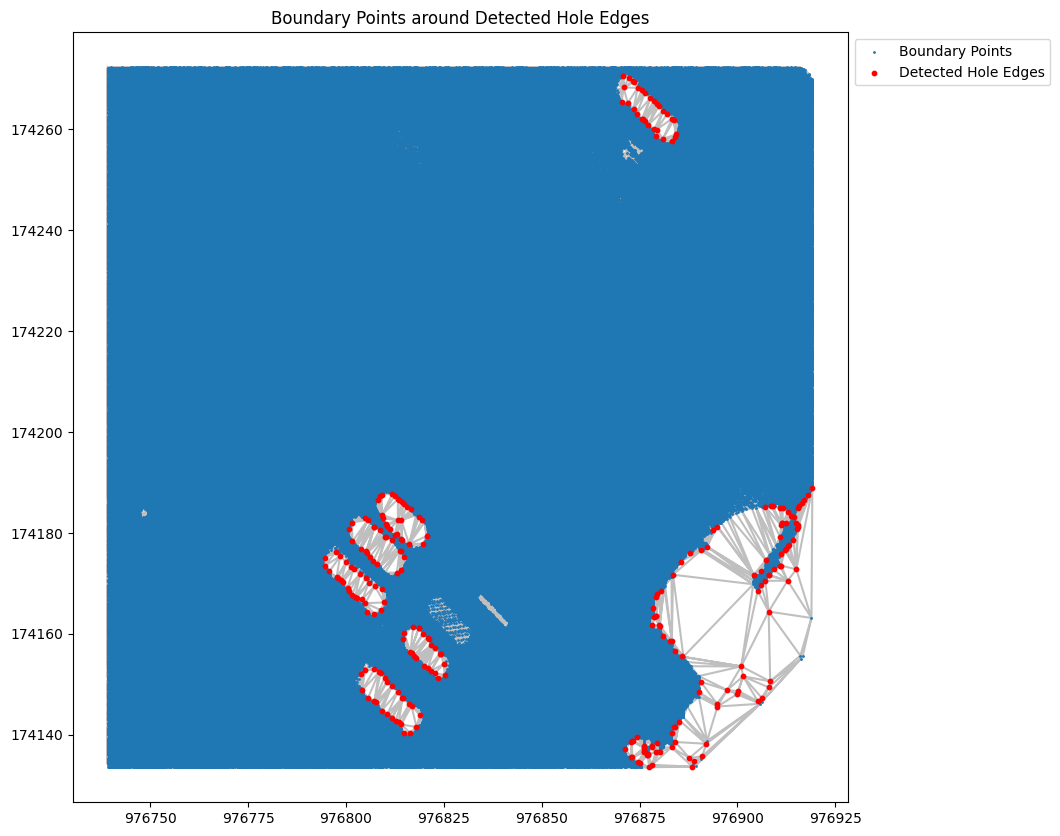

In [29]:
plt.figure(figsize=(10, 10))
plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Boundary Points', s=1)
plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label='Detected Hole Edges', s=10)
plt.title('Boundary Points around Detected Hole Edges')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()


average_spacing: 0.07414652159210637


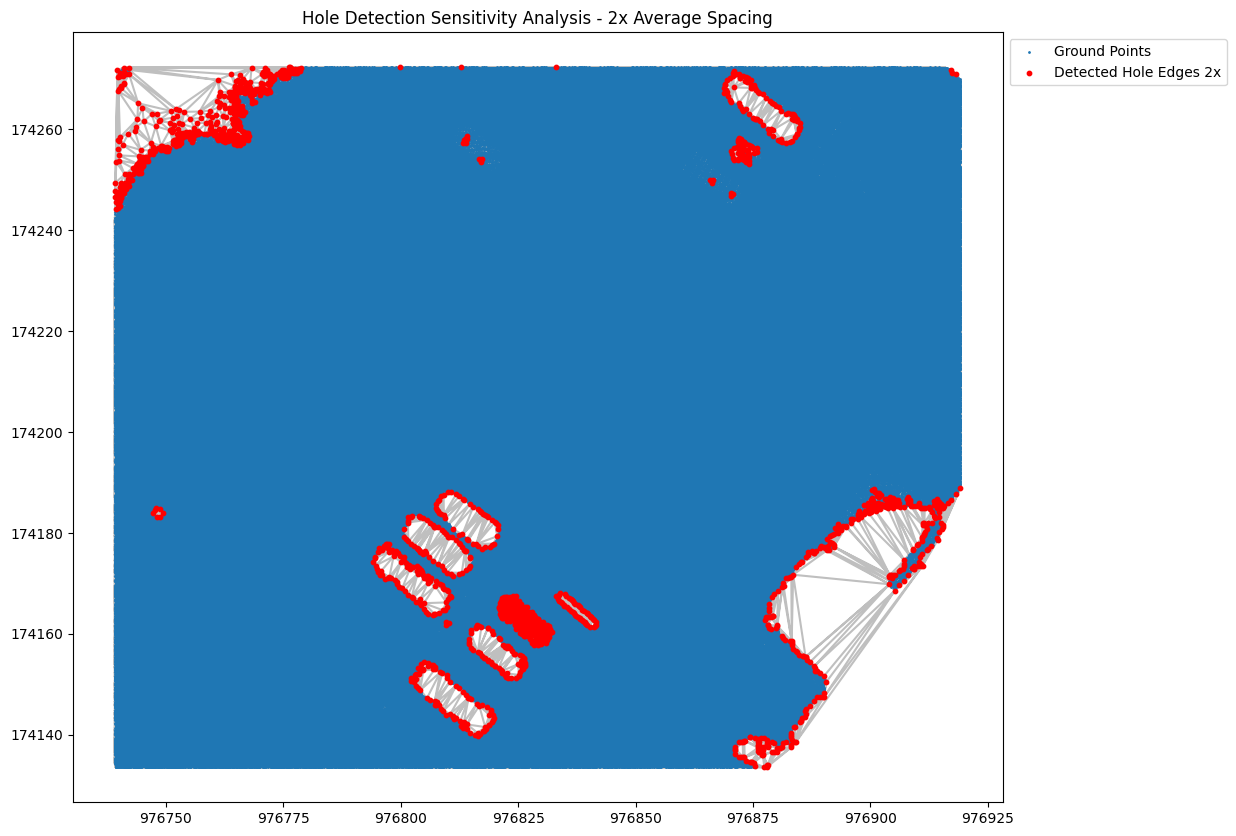

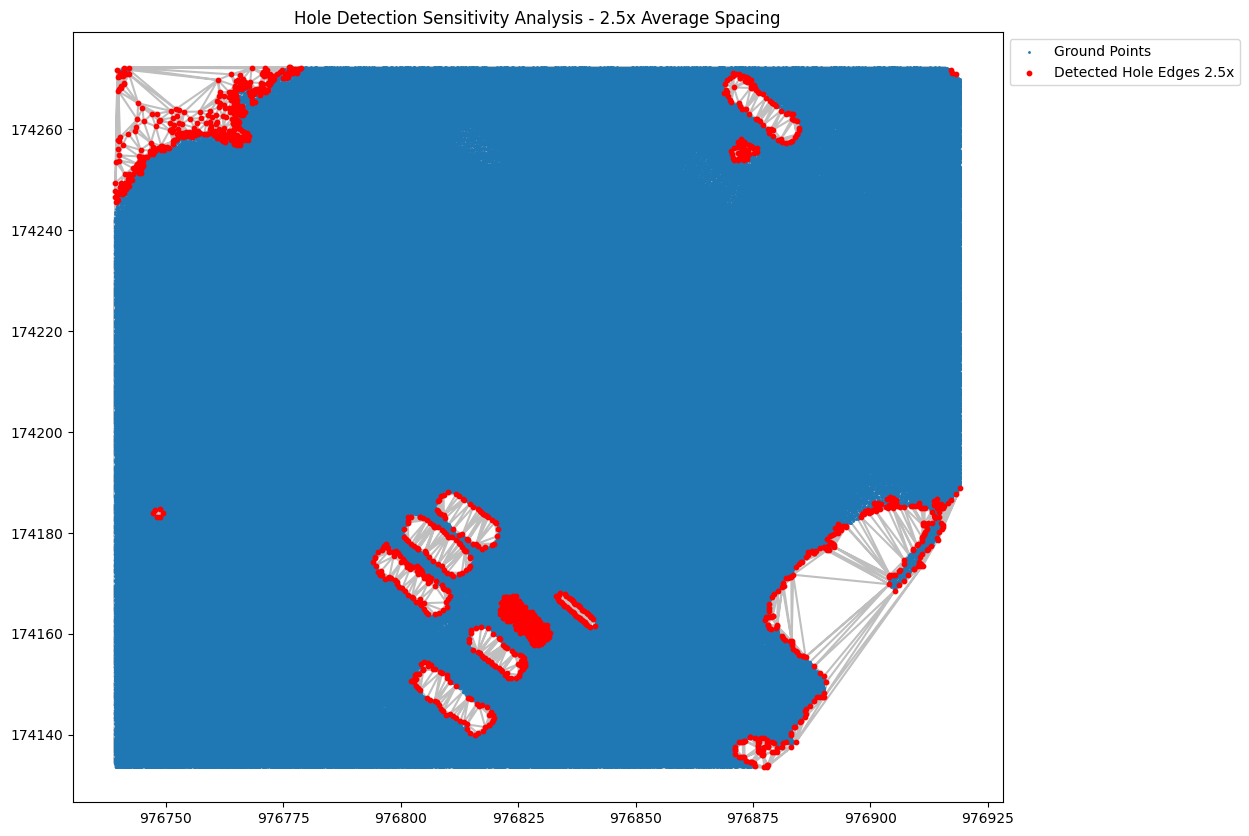

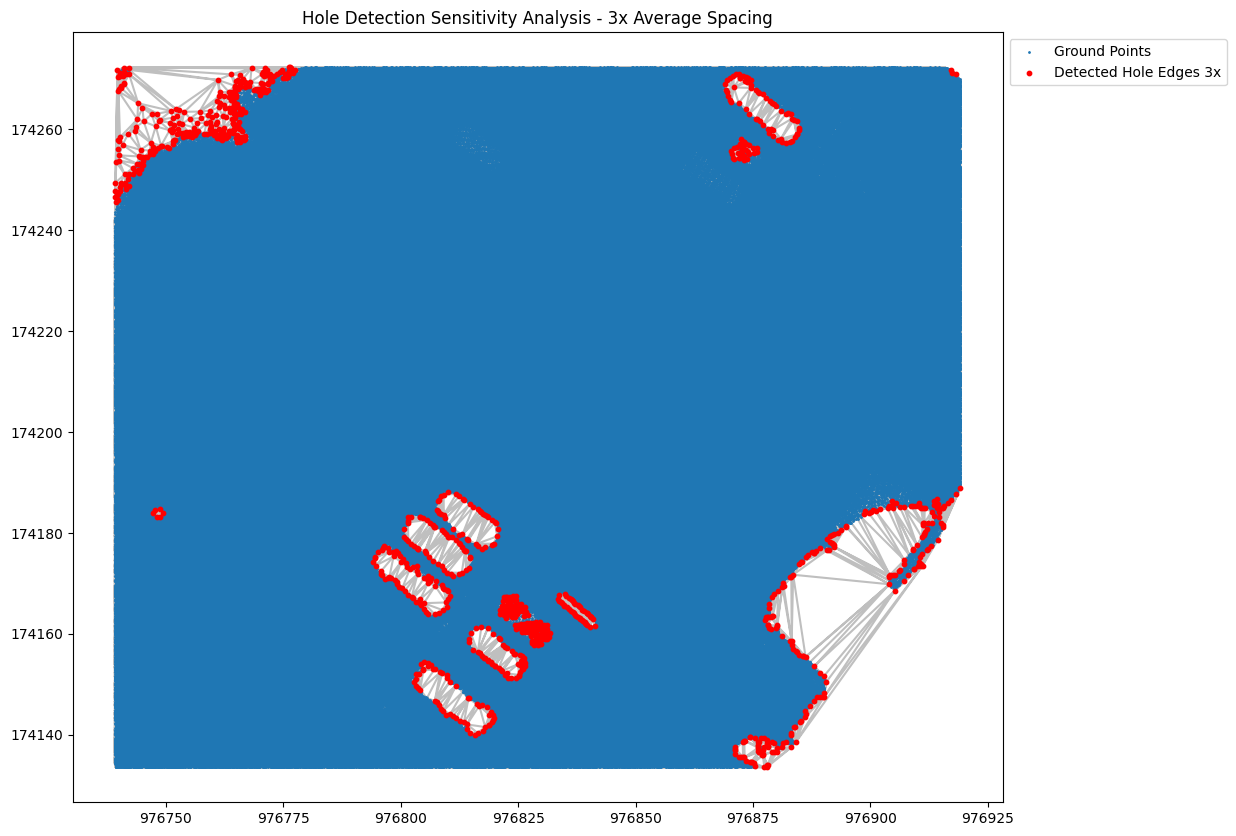

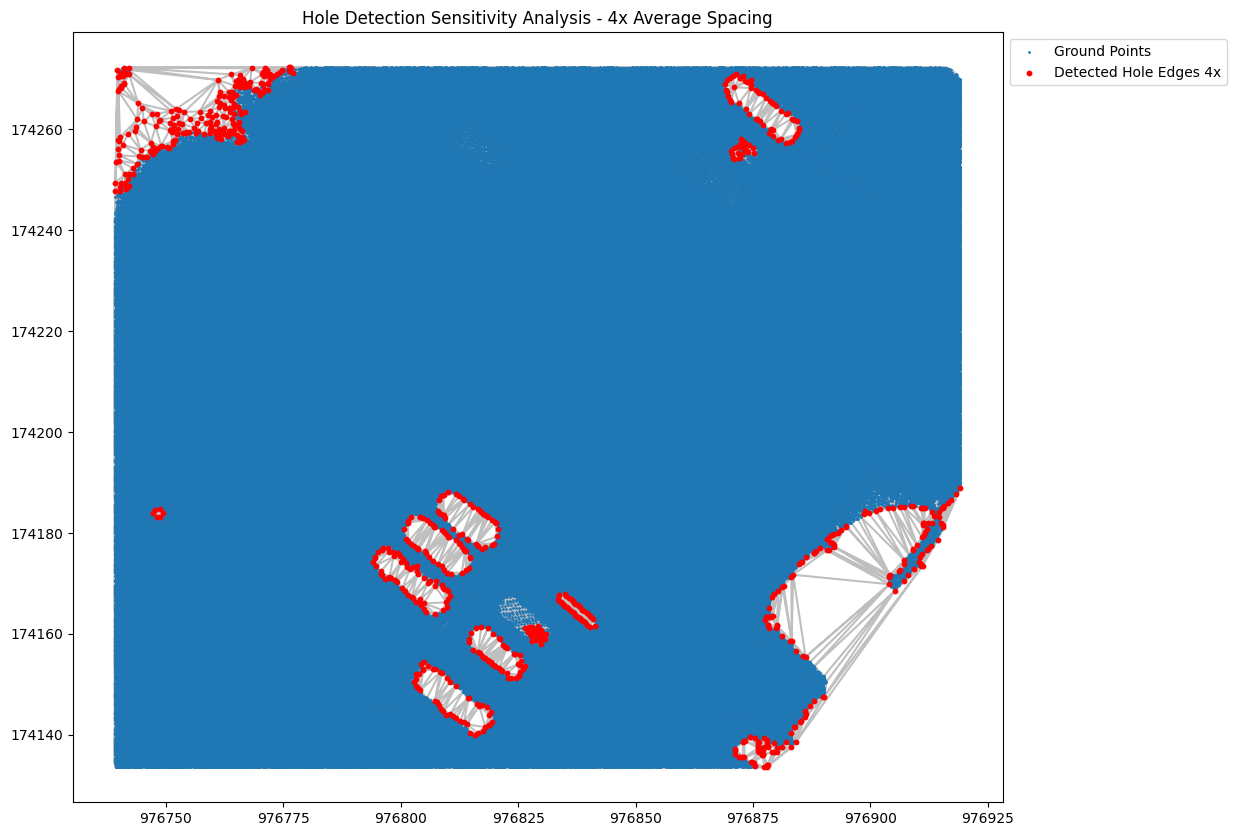

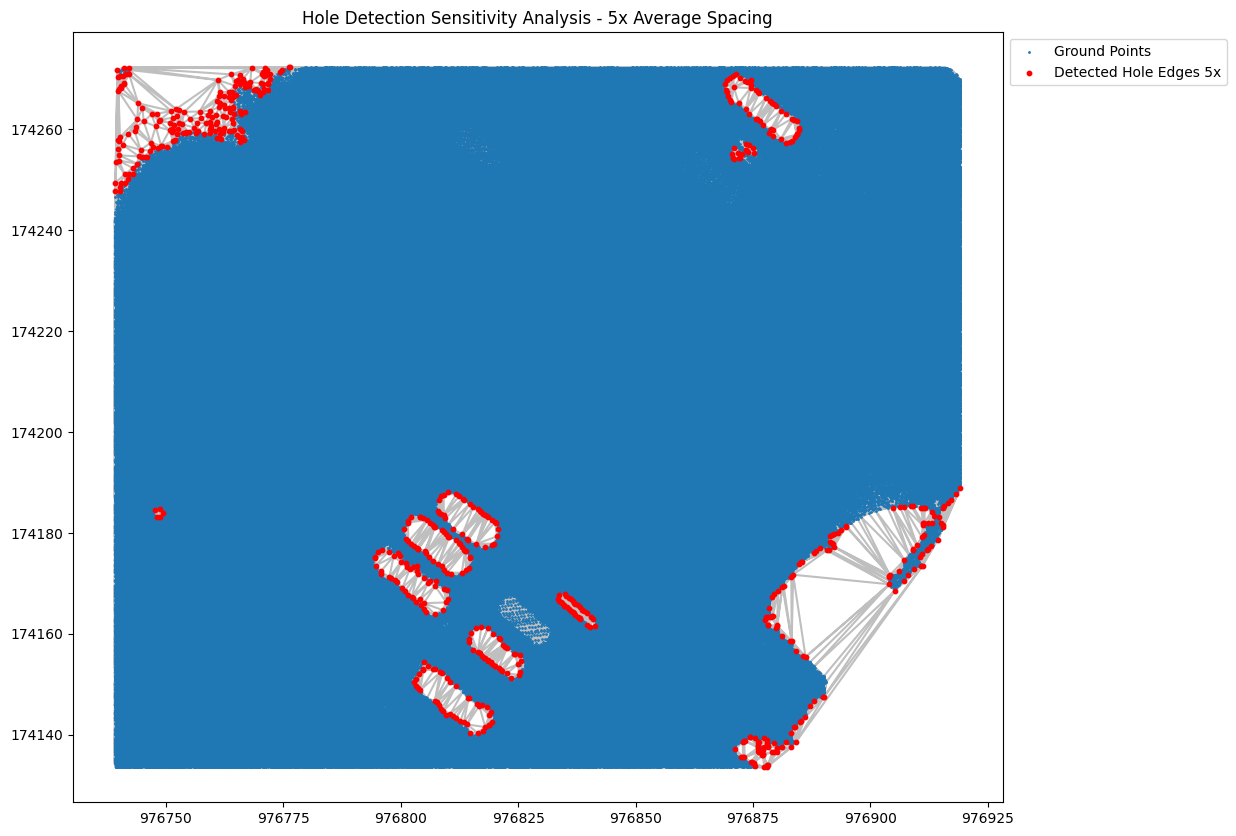

   Threshold Multiple  Points Around Holes
0                 2.0                 1488
1                 2.5                 1205
2                 3.0                  996
3                 4.0                  759
4                 5.0                  636


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def calculate_average_spacing(points_2d):
    tree = KDTree(points_2d)
    distances, _ = tree.query(points_2d, k=2) 
    average_spacing = np.mean(distances[:, 1])  
    return average_spacing

average_spacing = calculate_average_spacing(points_2d)
print(f"average_spacing: {average_spacing}")

multiples = [2, 2.5, 3, 4, 5]
results = []

for multiple in multiples:
    threshold_area = multiple * average_spacing
    max_area = 50 * average_spacing 
    aspect_ratio_threshold = 100 
    
    points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)
    
    plt.figure(figsize=(12, 10))
    plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
    plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Ground Points', s=1)
    plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label=f'Detected Hole Edges {multiple}x', s=10)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title(f'Hole Detection Sensitivity Analysis - {multiple}x Average Spacing')
    plt.show()

    # Record the results
    results.append({'Threshold Multiple': multiple, 'Points Around Holes': len(points_around_holes)})

# Create DataFrame
df_results = pd.DataFrame(results)
print(df_results)


In [22]:
df_results
df_results['str'] = df_results['Threshold Multiple'].astype(str)

In [24]:
df_results

,Threshold Multiple,Points Around Holes,str
0,2.0,1114,2.0
1,2.5,894,2.5
2,3.0,758,3.0
3,4.0,593,4.0
4,5.0,493,5.0


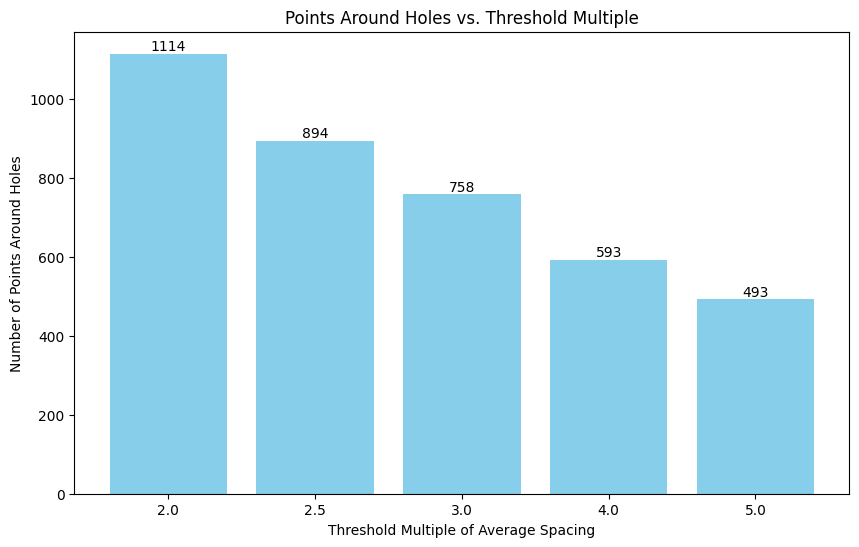

In [25]:

plt.figure(figsize=(10, 6))
bars = plt.bar(df_results['str'], df_results['Points Around Holes'], color='skyblue')

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), va='bottom', ha='center')  # Center the text by adjusting x position

plt.xlabel('Threshold Multiple of Average Spacing')
plt.ylabel('Number of Points Around Holes')
plt.title('Points Around Holes vs. Threshold Multiple')
plt.xticks(df_results['str'])  # Ensure ticks match the threshold multiples
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [9]:
calculate_average_spacing(points_2d)

0.07417840745472833

Max aspect ratios of all triangles: 1351.8761041048779 <br>
Mean aspect ratios of all triangles: 2.035603166641976